In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import logging
from tqdm import tqdm

import numpy as np
from scipy import interpolate
from astropy.io import fits
import jax.numpy as jnp

sys.path.append(os.environ['DM21CM_DIR'])
import dm21cm.physics as phys
from dm21cm.utils import load_h5_dict
from dm21cm.dm_params import DMParams
from dm21cm.evolve import get_z_edges
from dm21cm.interpolators_jax import BatchInterpolator

sys.path.append(os.environ['DH_DIR'])
import darkhistory
from darkhistory.spec.spectrum import Spectrum
from darkhistory.main import evolve as dh_evolve
from darkhistory.config import load_data as dh_load_data
print(darkhistory.__version__)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


1.0.0-dm21cm.0


In [2]:
tf_name = 'debug_231002'
abscs = load_h5_dict(os.environ['DM21CM_DIR'] + f"/data/abscissas/abscs_{tf_name}.h5")

In [3]:
rs = 38.71318413405634
xe = 0.1

In [3]:
abscs['x']

array([1.0000e-05, 3.3330e-05, 1.0000e-04, 3.3330e-04, 1.0000e-03,
       3.3330e-03, 1.0000e-02, 3.3330e-02, 1.0000e-01, 2.0000e-01,
       3.0000e-01, 5.0000e-01, 7.0000e-01, 8.0000e-01, 9.0000e-01,
       9.9000e-01, 9.9900e-01, 9.9990e-01, 9.9999e-01])

In [18]:
rs = 45.30667755087399+1
xe = 0.002

## DH_run

In [19]:
dep_tf = dh_load_data(
    'dep_tf',
    verbose=1,
    prefix="/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_debug_231002",
    force_reload=True
)

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_debug_231002
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******


In [20]:
dh_soln = dh_evolve(
    DM_process='decay', mDM=1.2e10, lifetime=1e24, primary='phot_delta',
    start_rs=rs, end_rs=rs/1.01,
    coarsen_factor=12, backreaction=True,
    init_cond=(xe, phys.chi*xe, 10*phys.kB),
    use_tqdm=False, verbose=1,
    cross_check_21cmfast=True,
    debug_bath_point_injection=True,
    debug_use_tf_dt=True,
)

Loading time: 0.000 s
Initialization time: 0.025 s
rs=46.30667755087399, bath point injection
(array([407, 410]),)
bath energy 44423.827715201114
eng per inj 12000000000.0
inj_per_Bavg 1.1125256230453793e-11
inj eng 0.1335030747654455
Main loop time: 0.072 s


/n/home07/yitians/darkhistory/DarkHistory/darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [21]:
f_dh = np.array([dh_soln['f']['low'][k] + dh_soln['f']['high'][k] for k in dh_soln['f']['low']])
f_dh = f_dh[:,0]

In [22]:
f_dh

array([1.51946658e-03, 2.59564716e-05, 1.27021998e-03, 1.00308540e-03,
       2.02890799e-04])

## 21 run

In [23]:
from dm21cm.evolve import evolve
import py21cmfast as p21c
from astropy.cosmology import Planck18

In [24]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'phot_delta',
    m_DM = 1.2e10,
    lifetime = 1e24,
)

return_dict = evolve(
    run_name = 'dhc_test',
    z_start = 46.2, # 38.2
    z_end = 4.96266792, # 4.96266792
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = 'debug_231002',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            SIGMA_8 = 1e-8, # Planck18.meta['sigma8']
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = ['uniform_xray'],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='../run_info',
    debug_dhc_delta_fixed=True,
    debug_use_tf_dt=True,
    debug_no_bath=True,
    debug_bath_point_injection=True,
    debug_break_after_z=45.,
    debug_dhc_DH_xe_func=lambda z : xe,
)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
INFO:root:Using 21cmFAST version 0.1.dev1581+g40959ca.d20230929
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test


INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial conditions.


get_init_cond 76.69051241902868 0.0010065095731422143
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
box_ct = 0
dzp = -4.256783e-01
zp = 4.576974e+01
dt_dzp = -5.478598e+13
dadia_dzp * dzp = -7.780616e-01
dspec_dzp * dzp = 0.000000e+00
dcomp_dzp * dzp = 5.069821e-02
dxheat_dzp * dzp = 0.000000e+00
input heating = 0.000000e+00
dxion_source = 0.000000e+00
dxion_sink = 3.005761e-07
T = 4.274325e+01
alpha_A(T) = 1.449264e-11
global_params.CLUMPING_FACTOR = 1.000000e+00
x_e = 2.138340e-04
f_H = 9.249617e-01
prefactor_1 = 2.102707e-02
curr_delNL0 = -2.190174e-06
growth_factor_zp = 2.721458e-02
input ionization = 0.000000e+00

N_b0 = 2.055340e-07
f_H = 9.249617e-01

dt 25472261010280.54 25646820891680.023
before 76.69054 0.0010065099
input_heating 2.3266489e-06
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
box_ct = 0
dzp = -4.630661e-01
zp = 4.530668e+01
dt_dzp = -5.616589e+13
dadia_dzp * dzp = -1.533808e+00
dspec_dzp * 

dt 25856886555192.566 26035771551956.367
bath energy 44423.695
eng per inj 12000000000.0
inj_per_Bavg 1.08370795e-11
inj eng 0.13004495397206384
(array([407]),)
(array([410]),)
before 75.30623 0.0010014642
input_heating 1.0061682
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
box_ct = 0
dzp = -4.584846e-01
zp = 4.484819e+01
dt_dzp = -5.758058e+13
dadia_dzp * dzp = -1.506134e+00
dspec_dzp * dzp = 0.000000e+00
dcomp_dzp * dzp = 1.455090e-01
dxheat_dzp * dzp = 0.000000e+00
input heating = 1.006168e+00
dxion_source = 0.000000e+00
dxion_sink = 4.976394e-06
T = 7.530623e+01
alpha_A(T) = 1.025815e-11
global_params.CLUMPING_FACTOR = 1.000000e+00
x_e = 1.001464e-03
f_H = 9.249617e-01
prefactor_1 = 1.980845e-02
curr_delNL0 = -2.146921e-06
growth_factor_zp = 2.776285e-02
input ionization = 1.487704e-05

N_b0 = 2.055340e-07
f_H = 9.249617e-01

after 74.951775 0.001011365
----- DM21CM -----
z 45.30667755087399
[3.64854923e-09 5.64393219e-11 3.10611865e-09 2.08976

In [25]:
# DM21CM:
# WARNING:root:Point injecting bath at z=37.713184
# dt 33860104410955.453 34050802162151.98
# bath energy 44423.695
# eng per inj 10000000000.000002
# inj_per_Bavg 1.7007892e-11
# inj eng 0.17007891622844443

In [26]:
# DarkHistory
# rs=38.71318413405634, bath point injection
# (array([407, 408]),)
# bath energy 44423.864291015205
# eng per inj 10000000000.0
# inj_per_Bavg 1.7007888885729e-11
# inj eng 0.17007888885729

In [27]:
# DM21CM:
# WARNING:root:Point injecting bath at z=45.30667755087399 ---------------------
# dt 25856886555192.566 26728107321173.67
# bath energy 44423.695
# eng per inj 12000000000.0
# inj_per_Bavg 1.1125254e-11
# inj eng 0.1335030523630376
# (array([407]),)
# (array([410]),)

In [28]:
# DH:
# rs=46.30667755087399, bath point injection
# (array([407, 410]),)
# bath energy 44423.827715201114
# eng per inj 12000000000.0
# inj_per_Bavg 1.1125256230453793e-11
# inj eng 0.1335030747654455

In [29]:
run_name = 'dhc_test'
soln = np.load(f"../run_info/{run_name}_records.npy", allow_pickle=True).item()

In [30]:
soln['f_heat']

array([0.00000000e+00, 2.36648678e-09, 1.00810744e-03, 2.32423525e-09])

In [31]:
f3_dm21cm = np.array([soln['f_ion'][2], soln['f_exc'][2], soln['f_heat'][2]])

In [32]:
f3_dh = np.array([f_dh[0] + f_dh[1], f_dh[2], f_dh[3]])

In [33]:
1 - f3_dm21cm / f3_dh

array([-0.01319811, -0.01592913, -0.0050066 ])

## compare

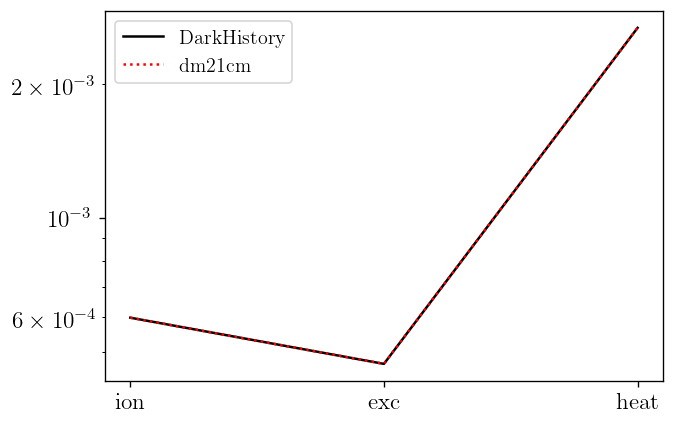

In [15]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

fig, ax = plt.subplots()

ax.plot(f3_dh, label='DarkHistory', color='k')
ax.plot(f3_dm21cm, label='dm21cm', color='r', ls=':')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['ion', 'exc', 'heat'])
ax.set(yscale='log')
#ax.set(ylim=(1e-7,1e-4))
ax.legend();

## A. HED pipeline

In [110]:
# .npy
data_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/zf01/phot"
hed_tfgv = np.load(f'{data_dir}/hed_tf_rxneo.npy')
hed_tfgv[8, 3, 6, 429]

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [111]:
# dm21cm tf
tf = np.load(f"{os.environ['DM21CM_DATA_DIR']}/tf/zf01/phot/hed_tf_rxneo.npy")
tf[8, 3, 6, 429]

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [134]:
# dhtf
dhtf = pickle.load(open(f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_zf01/highengdep_interp.raw", 'rb'))
dhtf.grid_vals[0][3, 0, 8, 429] * (abscs['dlnz'] / phys.hubble(abscs['rs'][-2]))

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [135]:
dhtf.get_val(0.01, 0.9, abscs['rs'][-2])[429] * (abscs['dlnz'] / phys.hubble(abscs['rs'][-2]))

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

correct!!